In [1]:
import pyart
import numpy as np
import matplotlib.pyplot as plt
import warnings
import glob
import copy
import os
import datetime
import scipy
import pandas as pd
import matplotlib.dates as mdates
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
np.set_printoptions(threshold=np.inf)
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)
%matplotlib inline


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [74]:
#Create empty data arrays for phiest and phiobs
#Sizes are the set at number of days by number of volumes by number of rays
#Volumes are approx 5-7 mins, number of volumes in any given day does not exceed 290 (24*60/290 = ~5mins)
#Each volume is 10 elevations by 360 degrees (10*360 = 3600)

#files on k9 directly
datadir = '/nfs/foe-data-32/export/ncas/earljbe/CHILBOLTON/calibrations/Zcalib_2020/phi_files/110620_att/'
#datadir = '/nfs/foe-data-32/export/ncas/earljbe/CHILBOLTON/calibrations/Zcalib_2020/phi_files/080620_norm/'

os.chdir(datadir)
filelist1 = glob.glob("phiest*")
filelist2 = glob.glob("phiobs*")
filelist1.sort()
filelist2.sort()

rsize = 4680

ndays=len(filelist1)
print ndays
phiest=np.zeros((ndays,290,rsize))*np.nan
phiobs=np.zeros((ndays,290,rsize))*np.nan

x=np.zeros((290,rsize))*np.nan

120


In [75]:
a1=0;a2=ndays;

In [4]:
filelist1[104]

'phiest_all_att_20180327.npy'

In [76]:
#Load each phiest and phiobs data for each day and store into 3D array. 
#Calculate number of good rays for each day/volume
#d and e are a counter for each day
d=0
e=0
dates=[]
#for day in filelist1[117:139]:
#for day in filelist1[0:106]:
for day in filelist1[:]:
    #print day
    if day[3:6]=='est':
        dates.append(day[15:23])
        #dates.append(day[11:19])
        phiest1 = np.load(datadir + day)
        #phiest1 = np.loadtxt(datadir + day)
        #print datadir+day
        [a,b] = phiest1.shape
        #print a,b
        #This loops over each volume 0 to a
        #for i in range(0,a):
            #print i,d
            #good_rays is a function of day 'd' and volume 'i'
            #sums total number of non-nan values, i.e. number of good rays in each volume
        #    good_rays[d,i] = np.sum(~np.isnan(phiest1[i,:]))
        phiest[d,0:a,0:b] = phiest1    
        d=d+1
    
#for day in filelist2[117:139]:    
#for day in filelist2[0:106]:    
for day in filelist2[:]:    
    if day[3:6]=='obs':
        phiobs1 = np.load(datadir + day)
        #phiobs1 = np.loadtxt(datadir + day)
        #print datadir+day
        [a,b] = phiobs1.shape
        phiobs[e,0:a,0:b] = phiobs1
        e=e+1
print a,b
print d,e

285 4680
120 120


In [86]:
dates[104]

'20180327'

In [7]:
#20200224 = 106
#20190724 = 42
#filelist1[42] 

# numrays = np.zeros((290,10))
# e1=0
# e2=360
# for vol in range(290):
#     for ele in range(10):
#         #print e1, e2, ele        
#         numrays[vol,ele] = np.nansum(np.isfinite(phiest[42,vol,e1:e2]).flatten())
#         if ele==9:
#             e1=0
#             e2=360
#         else:
#             e1=e1+360
#             e2=e2+360        

In [16]:
#for D in range(117,139):
#    print 'date = ', dates[D]
#    print 'numrays = ', np.sum(np.isfinite(phiest[D,:,:]))
#print dates[0], dates[116]
#filelist2[0:117]
#print dates

In [91]:
#bias_each_ray (ndays,nvols,nrays)
#Calculate a bias/offset for each individual ray

#Extract subset of dates
#d1=0
#d2=106
#bias_each_ray = (phiest[d1:d2,:,:] - phiobs[d1:d2,:,:]) / phiobs[d1:d2,:,:]

bias_each_ray = (phiest - phiobs) / phiobs
bias_each_ray.shape

(120, 290, 4680)

In [67]:
# good_rays=np.zeros((d,290))*np.nan
# #Calculate number of good rays in each volume good_rays(116,290)
# for j in range(d):    
#     for i in range(290):
#         good_rays[j,i] = np.nansum(np.isfinite(bias_each_ray[j,i,:]))

In [68]:
#print good_rays.shape, bias_each_ray.shape

(121, 290) (121, 290, 4680)


In [92]:
#bias_each_ray = bias_each_ray[0:106]
bias_each_ray = bias_each_ray[105:]
print bias_each_ray.shape

(15, 290, 4680)


In [93]:
#dd=len(filelist1)-105
dd=len(bias_each_ray)
print dd

good_rays=np.zeros((dd,290))*np.nan
#Calculate number of good rays in each volume good_rays(116,290)
for j in range(dd):    
    for i in range(290):
        good_rays[j,i] = np.nansum(np.isfinite(bias_each_ray[j,i,:]))

15


In [89]:
print good_rays.shape
#print np.sum(good_rays,axis=1)
#print ind[6,:]

(105, 290)


In [94]:
#Only use volumes with more than 10 good rays for calculation of overall bias.
ind = good_rays>10

#SINGLE VALUES FOR WHOLE TIME PERIOD
mean_bias = np.nanmean(bias_each_ray[ind,:])
mean_bias_db = 10.0*np.log10(1000+mean_bias*1000)-30

median_bias = np.nanmedian(bias_each_ray[ind,:])
median_bias_db = 10.0*np.log10(1000.0+median_bias*1000.0)-30.0

std = np.nanstd(bias_each_ray[ind,:])
std_db = 10.0*np.log10(1000.0+std*1000.0)-30.0


print 'Mean bias = ', mean_bias_db, 'Median bias = ', median_bias_db, 'Standard Deviation = ', std_db

Mean bias =  -5.613647268479021 Median bias =  -5.671871877236661 Standard Deviation =  0.3774905470532559


In [81]:
d=120
#DAILY VALUES OF BIAS
mean_bias_each_day=np.zeros(d)*np.nan
median_bias_each_day=np.zeros(d)*np.nan
std_each_day=np.zeros(d)*np.nan
std_error_each_day = np.zeros(d)*np.nan
num_rays_day=np.zeros(d)

for day in range(d):
        ind = good_rays[day,:]>10
        bias_one_day = bias_each_ray[day,ind,:].flatten()
        ind2 = np.isfinite(bias_one_day)        
        if np.sum(ind2)>0:
            std_error_each_day[day] = scipy.stats.sem(bias_one_day[ind2])

            mean_bias_each_day[day] = np.nanmean(bias_one_day)
            median_bias_each_day[day] = np.nanmedian(bias_one_day)
            std_each_day[day] = np.nanstd(bias_one_day)

            #Number of rays for each day
            num_rays_day[day] = np.sum(np.isfinite(bias_one_day))

mean_bias_each_day_db = 10.0*np.log10(1000.0+mean_bias_each_day*1000.0)-30.0
median_bias_each_day_db = 10.0*np.log10(1000.0+median_bias_each_day*1000.0)-30.0
std_each_day_db = 10.0*np.log10(1000.0+std_each_day*1000.0)-30.0
std_error_each_day_db = 10.0*np.log10(1000.0+std_error_each_day*1000.0)-30.0


In [82]:
#put data into dataframe
time = pd.to_datetime(dates, format = '%Y%m%d')
data = pd.DataFrame({'Mean Bias' : mean_bias_each_day_db, 'Median Bias' : median_bias_each_day_db, 
                     'Standard Error' : std_error_each_day_db, 'Standard Deviation' : std_each_day_db}, 
                    index=time)

In [68]:
#27/04/2019 First receiver fault
#04/07/2019 Radar operational again
#29/10/2019 Second receiver fault
#05/11/2019 Replaced board in RX, operational again


In [26]:
outdir = '/nfs/foe-data-32/export/ncas/earljbe/CHILBOLTON/calibrations/Zcalib_2020/'
os.chdir(outdir)

In [83]:
#st_date = pd.to_datetime('20161101')
#ed_date = pd.to_datetime('20180327')

st_date = pd.to_datetime('20161101')
ed_date = pd.to_datetime('20180531')

#st_date = pd.to_datetime('20180328')
#ed_date = pd.to_datetime('20180531')

(736269.0, 736845.0)

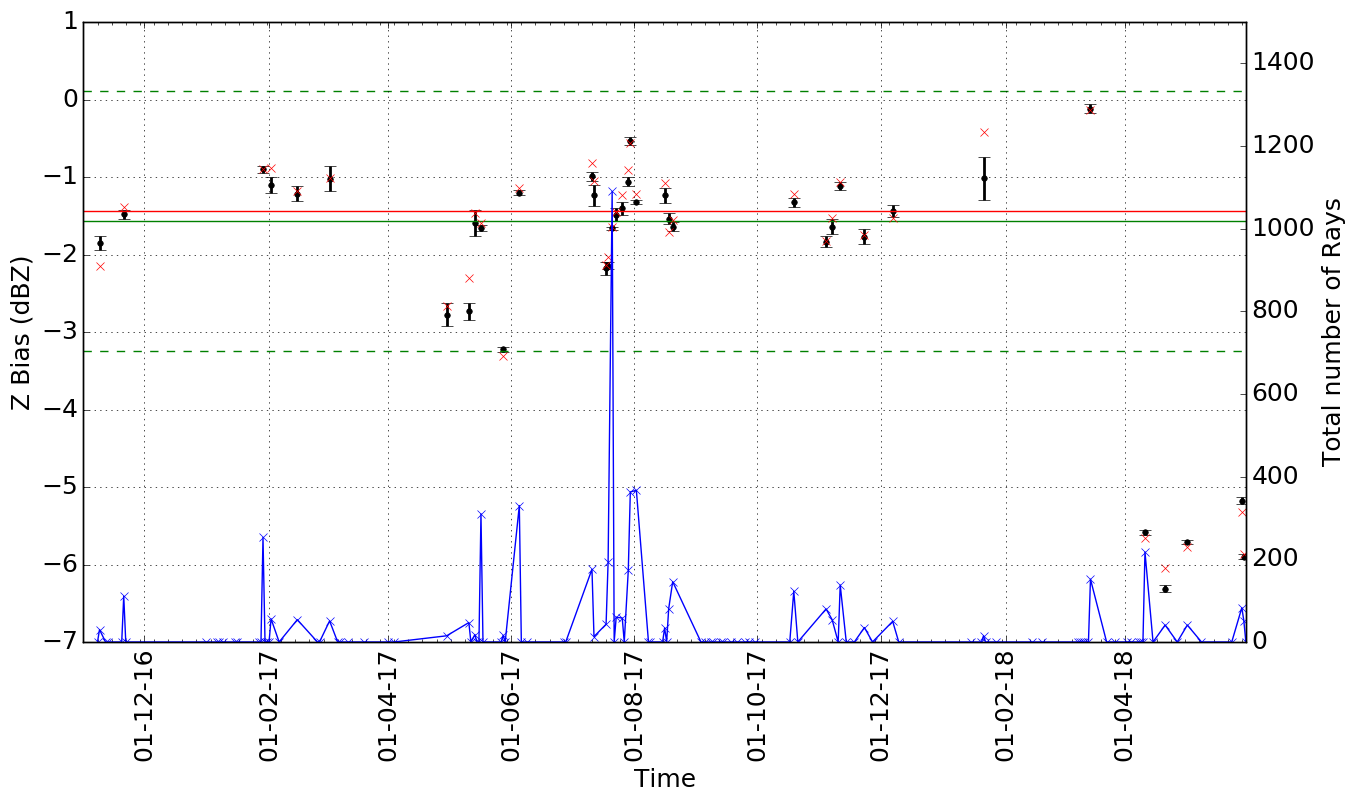

In [84]:
fig, ax1 = plt.subplots(figsize=(15,8))    
#plt.figure(figsize=(15,8))    
#for day in range(d):           
plt.errorbar(data.index, mean_bias_each_day_db, std_error_each_day_db, color='black',fmt='o',
                  markersize='4', elinewidth=2,capsize=4)

#plt.plot([pd.to_datetime('20190427'), pd.to_datetime('20190427')],[-10, 2],'b--')        
#plt.plot([pd.to_datetime('20191029'), pd.to_datetime('20191029')],[-10, 2],'b--')        

plt.plot([st_date, ed_date],[median_bias_db,median_bias_db],'r-')

plt.plot([st_date, ed_date],[mean_bias_db,mean_bias_db],'g')
plt.plot([st_date, ed_date],[mean_bias_db+std_db*2,mean_bias_db+std_db*2],'g--')
plt.plot([st_date, ed_date],[mean_bias_db-std_db*2,mean_bias_db-std_db*2],'g--')

plt.plot(data.index, median_bias_each_day_db,'rx')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y'))
#plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
#plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.gca().xaxis.set_minor_locator(mdates.WeekdayLocator(interval=1))
plt.xticks(rotation=90)
    
plt.xlabel('Time',{'fontsize':18})
plt.ylabel('Z Bias (dBZ)',{'fontsize':18})
#plt.xticks(np.arange(0,d,1),dates,rotation = 'vertical',size=12)
#plt.ylim(-4,0)
#plt.ylim(-7,-4.5)

plt.yticks(size=18)
plt.xticks(size=18)
#plt.xlim(pd.to_datetime('20180328'),pd.to_datetime('20180531'))
plt.grid()

ax2=ax1.twinx()
ax2.set_ylim(0,1500)
ax2.plot(data.index, num_rays_day,'bx-')
#ax2.set_yticks([5000, 10000])
#ax2.set_yticks([1000, 2000, 3000, 4000, 7500],minor=True)
plt.ylabel('Total number of Rays',{'fontsize':18})
plt.yticks(size=18)
plt.xlim(pd.to_datetime(st_date),pd.to_datetime(ed_date))

#imgname = outdir+'chilbolton_Zcalib_att_corr_20161101-20180327.png'
#imgname = outdir+'chilbolton_Zcalib_att_20180328-20180531.png'
#imgname = outdir+'chilbolton_Zcalib_norm_20161101-20180327.png'
#imgname = outdir+'chilbolton_Zcalib_norm_20180328-20180531.png'
#imgname = outdir+'chilbolton_Zcalib_whole_period.png'
#20161101-20180327.png'
#plt.tight_layout()
#plt.savefig(imgname,dpi=150)


In [72]:
print mean_bias_each_day_db[5]+4.6
print mean_bias_each_day_db[6:]+5.1

-0.9804014240257306
[        nan -1.21240479         nan -0.62089533         nan         nan
 -0.07682724 -0.79987843         nan]


In [50]:
volume_mean_bias = np.zeros((d,290))
volume_median_bias = np.zeros((d,290))
volume_std = np.zeros((d,290))
good_rays = np.zeros((d,290))

In [51]:
#BIAS FOR EACH VOLUME (13 PPIS)

#already got bias_each_ray derived above

for j in range(d):    
    for i in range(290):
# Sum number of good rays in each volume
        good_rays[j,i] = np.nansum(np.isfinite(phiest[j,i,:]))

        volume_mean_bias[j,i] = np.nanmean(bias_each_ray[j,i,:])
        volume_median_bias[j,i] = np.nanmedian(bias_each_ray[j,i,:])
        volume_std[j,i] = np.nanstd(bias_each_ray[j,i,:])
        
volume_mean_bias_db = 10.0*np.log10(1000.0+volume_mean_bias*1000.0)-30.0
volume_median_bias_db = 10.0*np.log10(1000.0+volume_median_bias*1000.0)-30.0
volume_std_db = 10.0*np.log10(1000.0+volume_std*1000.0)-30.0

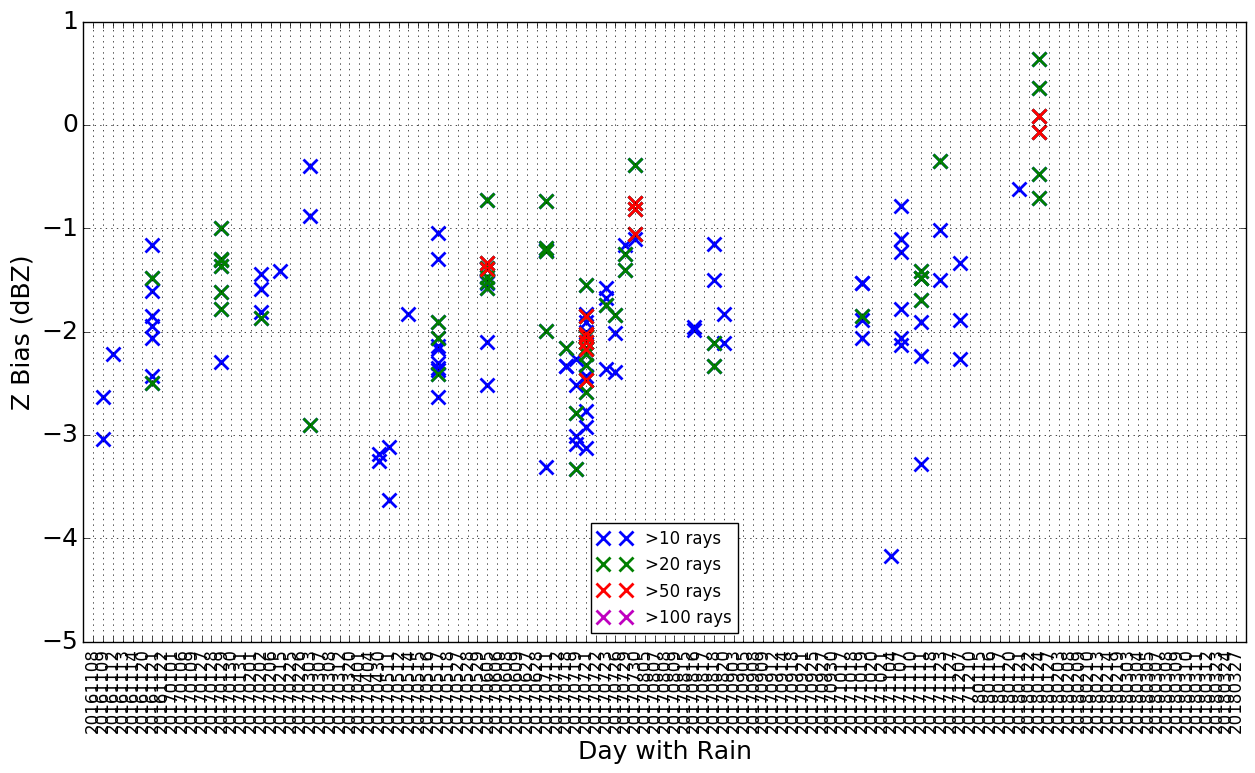

In [52]:
#good_rays is a function of day and volume (112,290)
#r values provide indices of where volumes meet threshold of number of good rays rX(a,b)
r0 = np.where(good_rays > 0)
r10 = np.where(good_rays > 9)
r20 = np.where(good_rays > 19)
r40 = np.where(good_rays > 39) 
r50 = np.where(good_rays > 49) 
r60 = np.where(good_rays > 59) 
r80 = np.where(good_rays > 79) 
r100 = np.where(good_rays > 99) 
r120 = np.where(good_rays > 119) 
r140 = np.where(good_rays > 139) 
#r1=np.where(good_rays < 2)

#b values extract bias values for each volume where number of good rays meets the threshold
#b1=volume_bias[good_rays<2]

bias = volume_mean_bias_db

b0 = bias[r0]
b10 = bias[r10]
b20 = bias[r20]
b40 = bias[r40]
b50 = bias[r50]
b60 = bias[r60]
b80 = bias[r80]
b100 = bias[r100]
b120 = bias[r120]
b140 = bias[r140]

plt.figure(figsize=(15,8))
#plt.plot(r0[0],b0,'kx',markersize=10,linewidth=2,mew=2,label='all rays')
plt.plot(r10[0],b10,'bx',markersize=10,linewidth=2,mew=2,label='>10 rays')
plt.plot(r20[0],b20,'gx',markersize=10,linewidth=2,mew=2,label='>20 rays')
plt.plot(r50[0],b50,'rx',markersize=10,linewidth=2,mew=2,label='>50 rays')
plt.plot(r100[0],b100,'mx',markersize=10,linewidth=2,mew=2,label='>100 rays')

plt.xlabel('Day with Rain',{'fontsize':18})
plt.ylabel('Z Bias (dBZ)',{'fontsize':18})
plt.xticks(np.arange(0,d,1),dates,rotation = 'vertical',size=12)

plt.yticks(size=18)
plt.xlim(-1,d)
#plt.xlim(104,113)
plt.grid()
plt.legend(loc=8)

In [53]:
#find each unique number of good_rays i.e. volumes have 1, 2....25, 27...29 good rays but none have 26 or 28 good rays
#So if you want to examine the bias for volumes with more than 25 rays, the answer will be the same for violumes with 
#more than 26 rays
nn = np.unique(good_rays)
#print nn
ln=len(nn)
#print ln
Nmedian=np.zeros(ln)
Nmean=np.zeros(ln)
Nstd=np.zeros(ln)
num_of_rays = np.zeros(ln)
num_of_vols = np.zeros(ln)
#range(ln)


In [54]:
#For each unique number of good rays in a volume, calculate the total number of good rays i.e. num_of_rays
#and the number of volumes containing that threshold of good rays num_of_vols

for N in range(ln):
    #volume_bias[good_rays>N].flatten()
        num_of_rays[N] = np.sum(good_rays[good_rays>nn[N]])
        num_of_vols[N] = len(np.where(good_rays>nn[N])[0])
        Nmean[N] = np.nanmean(volume_mean_bias[good_rays>nn[N]].flatten())
        Nmedian[N] = np.nanmedian(volume_median_bias[good_rays>nn[N]].flatten())
        
Nmean_db = 10.0*np.log10(1000.0+Nmean*1000.0)-30.0
Nmedian_db = 10.0*np.log10(1000.0+Nmedian*1000.0)-30.0


(-3, 0)

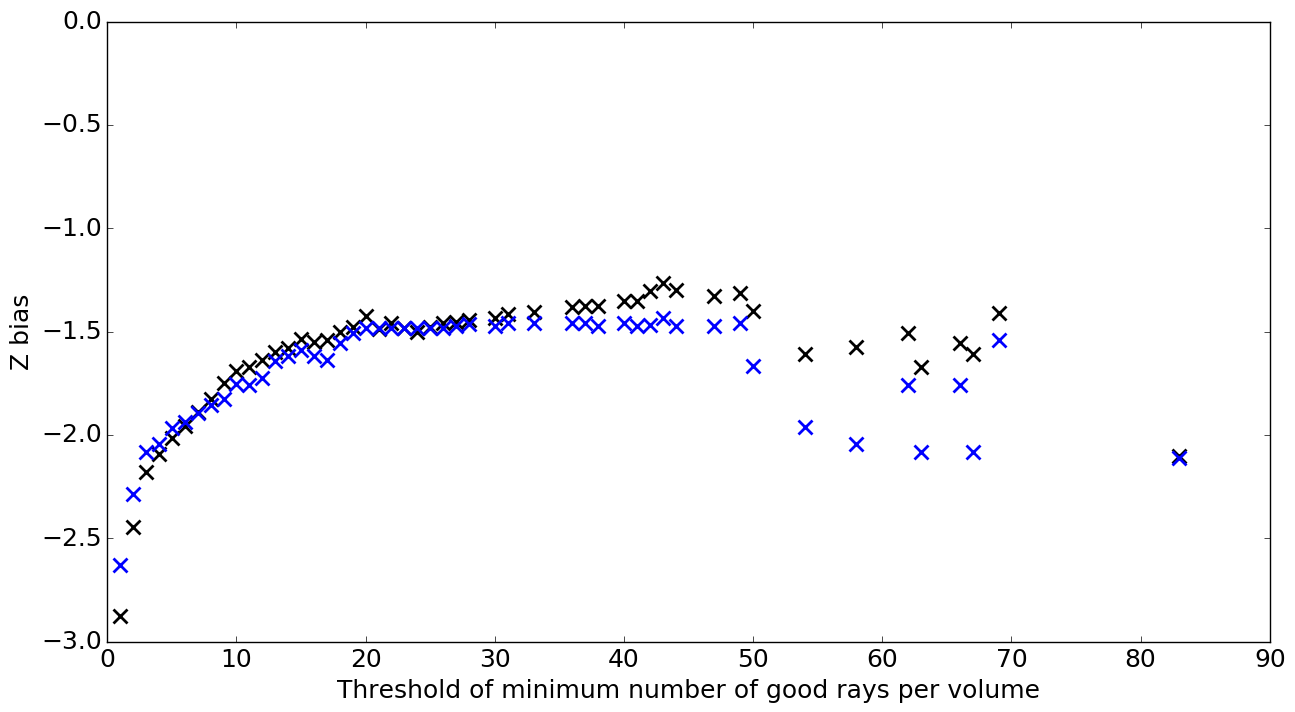

In [55]:
plt.figure(figsize=(15,8))
plt.plot(nn,Nmean_db,'kx',markersize=10,linewidth=2,mew=2)
plt.plot(nn,Nmedian_db,'bx',markersize=10,linewidth=2,mew=2)
#print np.nanmedian(Nmedian[30:40])
plt.xlabel('Threshold of minimum number of good rays per volume',{'fontsize':18})
plt.ylabel('Z bias',{'fontsize':18})
plt.yticks(size=18)
plt.xticks(size=18)
plt.ylim(-3, 0)
#plt.savefig(datadir + 'Z-bias_v_threshold.png')

(array([    0., 10000., 20000., 30000., 40000., 50000.]),
 <a list of 6 Text xticklabel objects>)

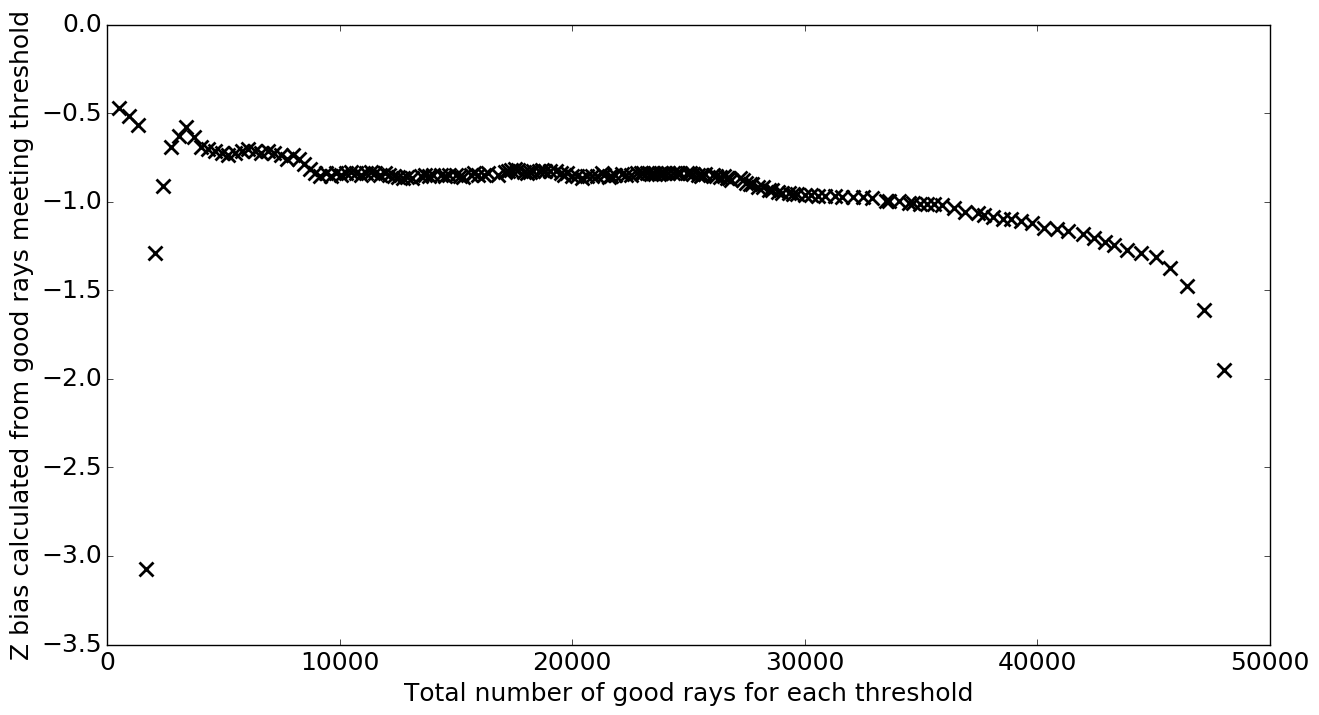

In [30]:
plt.figure(figsize=(15,8))
plt.plot(num_of_rays, Nmedian_db, 'kx',markersize=10,linewidth=2,mew=2)
plt.xlabel('Total number of good rays for each threshold',{'fontsize':18})
plt.ylabel('Z bias calculated from good rays meeting threshold',{'fontsize':18})
plt.yticks(size=18)
plt.xticks(size=18)